In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
class TimeSeriesData():
    
    def __init__(self,num_points,xmin,xmax):
        
        self.num_points = num_points
        self.xmin = xmin
        self.xmax = xmax
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax, num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self, x_series):
        return np.sin(x_series) #take series of x value and return sin of it
    
    def next_batch(self, batch_size, steps, return_batch_ts=False):
        #Grab a random starting point for each batch
        rand_start = np.random.rand(batch_size,1)
         
        #convert to be on time series
        ts_start = rand_start * (self.xmax * self.xmin) - (steps*self.resolution)
        
        #create a batch time series on the x axis
        batch_ts = ts_start + np.arange(0.0, steps+1) * self.resolution
        
        #create the Y data for the time series x axis from the previos step
        y_batch = np.sin(batch_ts)
        
        #formating for RNN
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1, steps, 1), y_batch[:,1:].reshape(-1,steps,1), batch_ts
        else:
            #first represent time seried second represents shifter 1 step ahead
            return y_batch[:,:-1].reshape(-1, steps, 1), y_batch[:,1:].reshape(-1,steps,1)

In [9]:
ts_data = TimeSeriesData(250,0,10)

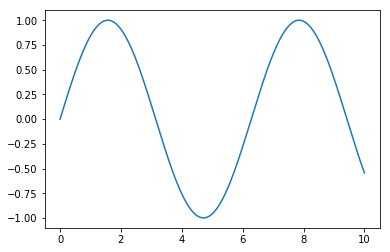

In [10]:
plt.plot(ts_data.x_data,ts_data.y_true)

In [26]:
num_time_steps = 30
y1, y2, ts = ts_data.next_batch(1, num_time_steps, True)

In [27]:
ts.shape

(1, 31)

In [28]:
ts #have to flatten this

array([[-1.2 , -1.16, -1.12, -1.08, -1.04, -1.  , -0.96, -0.92, -0.88,
        -0.84, -0.8 , -0.76, -0.72, -0.68, -0.64, -0.6 , -0.56, -0.52,
        -0.48, -0.44, -0.4 , -0.36, -0.32, -0.28, -0.24, -0.2 , -0.16,
        -0.12, -0.08, -0.04,  0.  ]])

In [29]:
ts.flatten().shape

(31,)

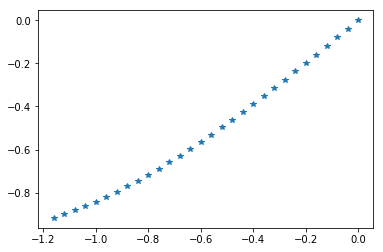

In [30]:
plt.plot(ts.flatten()[1:],y2.flatten(), '*')

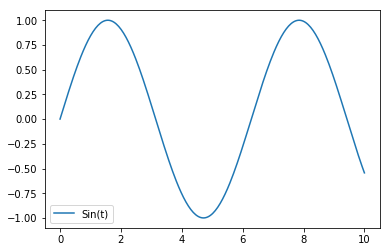

In [32]:
plt.plot(ts_data.x_data, ts_data.y_true, label='Sin(t)')
plt.legend()

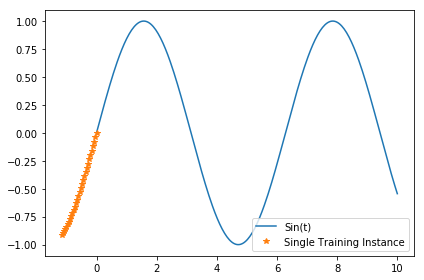

In [33]:
plt.plot(ts_data.x_data, ts_data.y_true, label='Sin(t)')
plt.plot(ts.flatten()[1:], y2.flatten(), '*', label = 'Single Training Instance')
plt.legend()
plt.tight_layout()

In [34]:
#Training Data 
train_inst = np.linspace(5, 5 + ts_data.resolution*(num_time_steps+1), num_time_steps+1)

In [35]:
train_inst

array([5.        , 5.04133333, 5.08266667, 5.124     , 5.16533333,
       5.20666667, 5.248     , 5.28933333, 5.33066667, 5.372     ,
       5.41333333, 5.45466667, 5.496     , 5.53733333, 5.57866667,
       5.62      , 5.66133333, 5.70266667, 5.744     , 5.78533333,
       5.82666667, 5.868     , 5.90933333, 5.95066667, 5.992     ,
       6.03333333, 6.07466667, 6.116     , 6.15733333, 6.19866667,
       6.24      ])

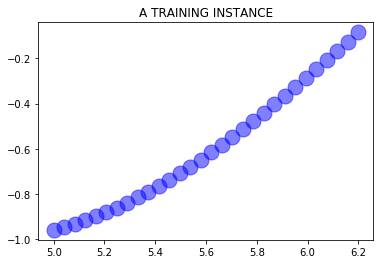

In [36]:
plt.title('A TRAINING INSTANCE')
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), 'bo', markersize=15, alpha=0.5, label='INSTANCE')

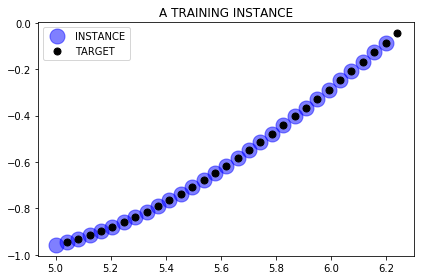

In [38]:
plt.title('A TRAINING INSTANCE')
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), 'bo', markersize=15, alpha=0.5, label='INSTANCE')
plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]), 'ko', markersize=7, label='TARGET')
plt.legend()
plt.tight_layout()

### Create the Model

In [39]:
tf.reset_default_graph()

In [40]:
num_inputs = 1
num_neurons = 100
num_outputs = 1
learning_Rate = 0.0001
num_train_iters = 2000
batch_size = 1

In [41]:
#placeholder
x = tf.placeholder(tf.float32,[None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32,[None, num_time_steps, num_outputs])

In [42]:
#RNN cell layer
cell = tf.contrib.rnn.BasicRNNCell(num_units = num_neurons, activation = tf.nn.relu)
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size = num_outputs)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [43]:
#perform fully dynamic unrolling of inputs
output, states = tf.nn.dynamic_rnn(cell,x,dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


In [44]:
#MSE
loss = tf.reduce_mean(tf.square(output-y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_Rate)
train = optimizer.minimize(loss)

In [47]:
init = tf.global_variables_initializer()

In [49]:
#sess
#if using gpu either no
#gpu_options = tf.GPUOption(per_process_gpu_memory_fraction=0.85)

saver = tf.train.Saver()

#with tf.Session(config = tf.COnfigProto(gpu_options = gpu_options)) as sess:
with tf.Session() as sess:
    sess.run(init)
    for iteration in range(num_train_iters):
        x_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict = {x:x_batch, y:y_batch})
        
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={x:x_batch, y:y_batch})
            print(iteration, '\tMSE', mse)
    saver.save(sess,'./saved_model')

0 	MSE 0.42102498
100 	MSE 0.057342634
200 	MSE 0.029753827
300 	MSE 0.021948436
400 	MSE 0.01739707
500 	MSE 0.014329714
600 	MSE 0.0121421
700 	MSE 0.010421103
800 	MSE 0.008993205
900 	MSE 0.007712194
1000 	MSE 0.0065262713
1100 	MSE 0.005442165
1200 	MSE 0.0044617835
1300 	MSE 0.0035879044
1400 	MSE 0.0028291955
1500 	MSE 0.0021699937
1600 	MSE 0.0016313583
1700 	MSE 0.0011976326
1800 	MSE 0.00085511594
1900 	MSE 0.0005934617


### Now predict one step ahead

In [51]:
with tf.Session() as sess:
    saver.restore(sess, './saved_model')
    
    x_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(output, feed_dict={x:x_new})

INFO:tensorflow:Restoring parameters from ./saved_model


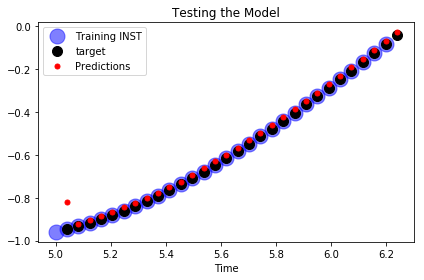

In [53]:
plt.title('Testing the Model')

#Training Instance
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), 'bo', markersize = 15, alpha =0.5, label = 'Training INST')
#Target to predict (correct test values np.sin(train))
plt.plot(train_inst[1:], np.sin(train_inst[1:]), 'ko', markersize = 10, label ='target')
#model predictions
plt.plot(train_inst[1:], y_pred[0,:,0], 'r.', markersize = 10, label = 'Predictions')

plt.xlabel('Time')
plt.legend()
plt.tight_layout()

### Now using GRU

In [54]:
tf.reset_default_graph()

In [55]:
num_inputs = 1
num_neurons = 100
num_outputs = 1
learning_Rate = 0.001
num_train_iters = 2000
batch_size = 1

In [56]:
#placeholder
x = tf.placeholder(tf.float32,[None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32,[None, num_time_steps, num_outputs])

#RNN cell layer
cell = tf.contrib.rnn.GRUCell(num_units = num_neurons, activation = tf.nn.relu)
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size = num_outputs)

#perform fully dynamic unrolling of inputs
output, states = tf.nn.dynamic_rnn(cell,x,dtype=tf.float32)
#MSE
loss = tf.reduce_mean(tf.square(output-y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_Rate)
train = optimizer.minimize(loss)
init = tf.global_variables_initializer()
#sess
#if using gpu either no
#gpu_options = tf.GPUOption(per_process_gpu_memory_fraction=0.85)

saver = tf.train.Saver()

#with tf.Session(config = tf.COnfigProto(gpu_options = gpu_options)) as sess:
with tf.Session() as sess:
    sess.run(init)
    for iteration in range(num_train_iters):
        x_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict = {x:x_batch, y:y_batch})
        
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={x:x_batch, y:y_batch})
            print(iteration, '\tMSE', mse)
    saver.save(sess,'./saved_model_gru')

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
0 	MSE 0.25950938
100 	MSE 0.0148506025
200 	MSE 0.005179097
300 	MSE 0.0014857972
400 	MSE 0.00013536934
500 	MSE 2.3442533e-06
600 	MSE 6.0298946e-05
700 	MSE 6.9813573e-09
800 	MSE 2.5375002e-09
900 	MSE 5.198657e-07
1000 	MSE 6.2163403e-09
1100 	MSE 3.919132e-09
1200 	MSE 2.1442227e-06
1300 	MSE 8.559788e-09
1400 	MSE 5.346279e-09
1500 	MSE 1.2693713e-05
1600 	MSE 1.6498763e-08
1700 	MSE 7.878254e-09
1800 	MSE 5.0012123e-09
1900 	MSE 9.590972e-05


In [57]:
with tf.Session() as sess:
    saver.restore(sess, './saved_model_gru')
    
    x_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(output, feed_dict={x:x_new})

INFO:tensorflow:Restoring parameters from ./saved_model_gru


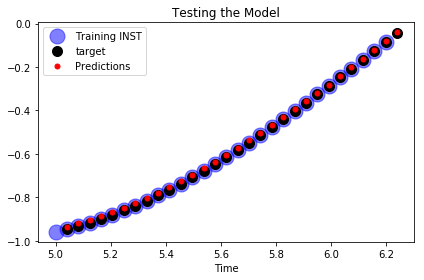

In [58]:
plt.title('Testing the Model')

#Training Instance
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), 'bo', markersize = 15, alpha =0.5, label = 'Training INST')
#Target to predict (correct test values np.sin(train))
plt.plot(train_inst[1:], np.sin(train_inst[1:]), 'ko', markersize = 10, label ='target')
#model predictions
plt.plot(train_inst[1:], y_pred[0,:,0], 'r.', markersize = 10, label = 'Predictions')

plt.xlabel('Time')
plt.legend()
plt.tight_layout()

- MUch Better

### Generating New Sequence

In [64]:
with tf.Session() as sess:
    saver.restore(sess, './saved_model_gru')
    
    #seed zero
    zero_seq_seed = [0.0 for i in range(num_time_steps)]
    
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        
        x_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1, num_time_steps,1)
        y_pred = sess.run(output, feed_dict={x:x_batch})
        zero_seq_seed.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./saved_model_gru


Text(0, 0.5, 'Y')

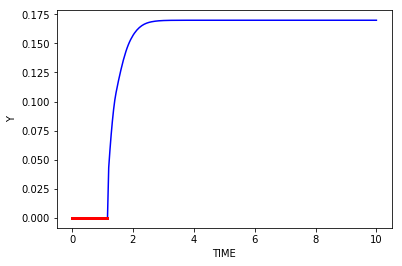

In [65]:
plt.plot(ts_data.x_data, zero_seq_seed, 'b-')
plt.plot(ts_data.x_data[:num_time_steps], zero_seq_seed[:num_time_steps], 'r', linewidth = 3)
plt.xlabel('TIME')
plt.ylabel('Y')

In [66]:
with tf.Session() as sess:
    saver.restore(sess, './saved_model_gru')
    
    #seed zero
    training_instance = list(ts_data.y_true[:30])
    
    for iteration in range(len(training_instance) - num_time_steps):
        
        x_batch = np.array(training_instance[-num_time_steps:]).reshape(1, num_time_steps,1)
        y_pred = sess.run(output, feed_dict={x:x_batch})
        training_instance.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./saved_model_gru


Text(0, 0.5, 'Y')

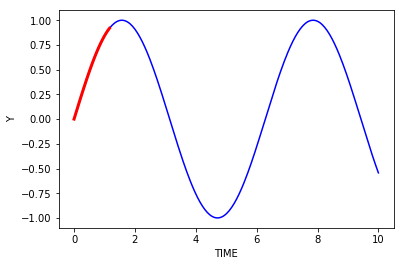

In [67]:
plt.plot(ts_data.x_data, ts_data.y_true, 'b-')
plt.plot(ts_data.x_data[:num_time_steps], training_instance[:num_time_steps], 'r', linewidth = 3)
plt.xlabel('TIME')
plt.ylabel('Y')